#Imports

In [ ]:
# ONLY FOR LUKAS
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
from IPython.display import display

!pip install spacy
!python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load('en_core_web_lg')

#to split the data
from sklearn.model_selection import train_test_split

#to do tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#to do cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

#to do LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#to get BERT embeddings
!pip install transformers
!pip install torch
import torch
from transformers import DistilBertModel, DistilBertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-26 09:19:34.967340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Create Dataframe from Datasets

In [ ]:
#import datasets
aliens = pd.read_csv('sf_aliens.csv')
aliens["type"] = "aliens"
history =pd.read_csv('sf_alternate_history.csv')
history["type"] = "history"
universe=pd.read_csv('sf_alternate_universe.csv')
universe["type"] = "universe"
apocalyptic = pd.read_csv('sf_apocalyptic.csv')
apocalyptic["type"] = "apocalyptic"
cyberpunk =pd.read_csv('sf_cyberpunk.csv')
cyberpunk["type"] = "cyberpunk"
dystopia = pd.read_csv('sf_dystopia.csv')
dystopia["type"] = "dystopia"
hard=pd.read_csv('sf_hard.csv')
hard["type"] = "hard"
military=pd.read_csv('sf_military.csv')
military["type"] = "military"
robots=pd.read_csv('sf_robots.csv')
robots["type"] = "robots"
space=pd.read_csv('sf_space_opera.csv')
space["type"] = "space opera"
steampunk=pd.read_csv('sf_steampunk.csv')
steampunk["type"] = "steampunk"
time_travel=pd.read_csv('sf_time_travel.csv')
time_travel["type"] = "time travel"

In [ ]:
# create a list of dataframes to concatenate
dfs = [aliens, history, universe, apocalyptic, cyberpunk, dystopia,
       hard, military, robots, space, steampunk, time_travel]

# concatenate dataframes using pd.concat
df = pd.concat(dfs, ignore_index=True)


In [ ]:
df

In [ ]:
# loop over groups of duplicated books and update types
for title, group in df.groupby(['Book_Title', 'Author_Name']):
    if len(group) > 1:
        # if there are duplicates, concatenate types
        types = ', '.join(sorted(set(group['type'].tolist())))
        df.loc[group.index, 'type'] = types

        # drop duplicates
        df.drop_duplicates(subset=['Book_Title', 'Author_Name'], keep='first', inplace=True)


In [ ]:
# df.dropna removes rows/columns with missing (NaN) values
df_cleaned = df.dropna(subset=["Book_Description", "Book_Title"])
df_cleaned

# Preprocessing

In [ ]:
# remove unnecessary columns
columns_to_remove = ['Original_Book_Title', 'url', 'Review_number'] # replace with the names of the columns you want to remove
df_cleaned = df_cleaned.drop(columns_to_remove, axis=1)
print(df_cleaned.columns.tolist())

['Book_Title', 'Author_Name', 'Edition_Language', 'Rating_score', 'Rating_votes', 'Book_Description', 'Year_published', 'Genres', 'type']


In [ ]:
#preprocessing, tokenizing, lemmatizing
def preprocess_text(text):
    # Tokenization and case folding
    doc = nlp(text.lower())

    # Lemmatization
    normalized_tokens = []
    for token in doc:
        if not token.is_punct and not token.is_space and not token.is_stop:
            normalized_token = token.lemma_
            normalized_tokens.append(normalized_token)

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(normalized_tokens)
    return preprocessed_text

In [ ]:
# lower case everything
string_cols = ['Book_Title', 'Author_Name', 'Edition_Language', 'Book_Description', 'Genres', 'type']
df_cleaned[string_cols] = df_cleaned[string_cols].apply(lambda x: x.str.lower())

In [ ]:
# Preprocess description column --> ca 8 min!
df_cleaned['Book_Description'] = df_cleaned['Book_Description'].apply(preprocess_text)

In [ ]:
df_cleaned.head()

In [ ]:
len(df_cleaned)

#Get BERT embeddings

In [ ]:
model_name = 'distilbert-base-uncased'

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def get_embeddings(texts, batch_size=32):
    embeddings = []

    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Make sure batch_texts is a list of strings
        batch_texts = [str(text) for text in batch_texts]

        # Tokenize the texts in the batch and convert to input IDs
        inputs = tokenizer(batch_texts, add_special_tokens=True, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

        # Move inputs to GPU if available
        inputs = inputs.to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the last hidden state (the embeddings)
        batch_embeddings = outputs.last_hidden_state
        # Calculate the mean of the embeddings
        batch_embeddings = torch.mean(batch_embeddings, dim=1).cpu().numpy()

        embeddings.extend(batch_embeddings)

    return embeddings

In [ ]:
# Compute embeddings for each description in batches
df_cleaned['bert_embedding'] = get_embeddings(df_cleaned['Book_Description'].tolist())

# Save DataFrame with embeddings to a .pkl file
df_cleaned.to_pickle('df_cleaned_with_medium_embeddings.pkl')

#**START**: Split Data

In [ ]:
# Open the pickle file (the one with embeddings) and load the data
with open('df_cleaned_with_medium_embeddings.pkl', 'rb') as f:
    clean_data_with_embed = pickle.load(f)

# Split the clean embedddings data into train (80%) validation(10%), and test (10%)
train_data, remaining_data = train_test_split(clean_data_with_embed, test_size=0.2, random_state=50)
valid_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=50)

# Print the shapes of the resulting sets
print("Train set shape:", train_data.shape)
print("Validation set shape:", valid_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (8820, 11)
Validation set shape: (1102, 11)
Test set shape: (1103, 11)


#Get cosine similarities

In [ ]:
# helper for tfidf vectors
def get_tfidf_vectors(data):
  # Create a TF-IDF matrix of the book descriptions
  tfidf = TfidfVectorizer()

  # Ensure all book descriptions are strings
  data['Book_Description'] = data['Book_Description'].apply(lambda x: str(x))

  # Fit the TF-IDF vectorizer on the training set and transform the training set
  tfidf_vectors = tfidf.fit_transform(data['Book_Description'])

  return tfidf_vectors


###TF-IDF

In [ ]:
def get_tfidf_cos_sim(data):

  tfidf_vectors = get_tfidf_vectors(data)

  # Compute the cosine similarity matrix
  cosine_sim_tfidf = cosine_similarity(tfidf_vectors, tfidf_vectors)

  return cosine_sim_tfidf

###LSA

analyzes relationships between a set of documents and the terms contained within

In [ ]:
def get_lsa_cos_sim(data):

  tfidf_matrix = get_tfidf_vectors(data)

  # Apply Singular Value Decomposition (SVD) on the TF-IDF matrix of the data
  svd = TruncatedSVD(n_components=100, random_state=42)
  X_lsa = svd.fit_transform(tfidf_matrix)

  # Compute the cosine similarity matrix for the data
  cosine_sim_lsa = cosine_similarity(X_lsa, X_lsa)

  return cosine_sim_lsa

###BERT

In [ ]:
def get_bert_cos_sim(data):

  # Convert the lists of embeddings into a 2D NumPy array
  embeddings = np.vstack(data['bert_embedding'].values)

  # Cosine Similarity on bert embeddings
  cosine_sim_bert = cosine_similarity(embeddings, embeddings)

  return cosine_sim_bert

#Get Recommendations

In [ ]:
def preprocess_query(query):

    # Check if the query is a string
    if not isinstance(query, str):
        print("Query must be a string")
        return

    # Tokenization and case folding
    query = nlp(query.lower())

    normalized_tokens = []
    for token in query:
        if not token.is_punct and not token.is_space:
            normalized_tokens.append(token.text)

    # Join the tokens back into a single string
    preprocessed_query = ' '.join(normalized_tokens)
    return preprocessed_query

In [ ]:
def get_recommendations(data, unique_key, cosine_sim, release_year=None, rank_by_score=False):

    unique_key = preprocess_query(unique_key)

    # Reset index in case any rows were dropped
    df = data.reset_index(drop=True)

    # Create a reverse mapping of book titles and DataFrame indices
    indices = pd.Series(df.index, index=df['Book_Title']).drop_duplicates()
    rating_scores = data['Rating_score']

    # Get the index of the book that matches the unique key
    idx = indices.get(unique_key)

    # Handle case when there are no search results
    if idx is None:
        print("No search results found for the query")

    # Handle case where idx is a Series of values
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    if rank_by_score:
        # Combine similarity scores and rating scores
        weighted_scores = [(i, sim_scores[i][1] * rating_scores[i]) for i in range(len(sim_scores))]
        # Sort the books based on the rating scores
        weighted_scores = sorted(weighted_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 10 most similar books
        weighted_scores = weighted_scores[1:11]
        # Get the book indices
        book_indices = [i[0] for i in weighted_scores]
    else:
        # Sort the books based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the scores of the 10 most similar books
        sim_scores = sim_scores[1:11]
        # Get the book indices
        book_indices = [i[0] for i in sim_scores]

    # Filter books up to release year if provided
    #if release_year is not None:
    #    book_indices = [idx for idx in book_indices if df['Year_published'].iloc[idx] > release_year]

    # Sort the books based on the score in descending order
    sorted_books = df.loc[book_indices, ['Book_Title', 'Rating_score','Author_Name', 'Year_published']].sort_values(by='Rating_score', ascending=False).reset_index(drop=True)

    # Return the top 10 most similar books along with their titles, rating scores, and release years
    return sorted_books #df.loc[book_indices, ['Book_Title', 'Rating_score', 'Year_published']].reset_index(drop=True)


##On train data

In [ ]:
# get cosine similarity for TRAIN_DATA
cosine_sim_tfidf_train = get_tfidf_cos_sim(train_data)
cosine_sim_lsa_train = get_lsa_cos_sim(train_data)
cosine_sim_bert_train = get_bert_cos_sim(train_data)

In [ ]:
# call function get_recommendations with TRAIN_DATA

result_train_bert = get_recommendations(train_data, 'outlander', cosine_sim_bert_train)
result_train_tfidf = get_recommendations(train_data, "outlander", cosine_sim_tfidf_train)
result_train_lsa = get_recommendations(train_data, "outlander", cosine_sim_lsa_train)

print('BERT')
display(result_train_bert)
print(' \n \n TF-IDF')
display(result_train_tfidf)
print(' \n \n LSA')
display(result_train_lsa)


BERT


,Book_Title,Rating_score,Author_Name,Year_published
0,the outlander series,4.73,diana gabaldon,2012
1,dragonfly in amber,4.32,diana gabaldon,1992
2,the space between,4.25,diana gabaldon,2012
3,the scottish prisoner,4.21,diana gabaldon,2011
4,unknown,4.14,wendy higgins,2016
5,fate's monolith,3.92,sky purington,2007
6,lost in the mist of time,3.92,karen michelle nutt,2006
7,"the ouroboros cycle, book one: a monster's com...",3.86,g.d. falksen,2013
8,master of the highlands,3.81,veronica wolff,2008
9,the revolution business,3.62,charles stross,2009


 
 
 TF-IDF


,Book_Title,Rating_score,Author_Name,Year_published
0,the outlander series,4.73,diana gabaldon,2012
1,dragonfly in amber,4.32,diana gabaldon,1992
2,drums of autumn,4.32,diana gabaldon,1996
3,gladly beyond,4.23,nichole van,2016
4,"magnificent devices bundle, volume 1",4.22,shelley adina,2013
5,a gentleman of means,4.18,shelley adina,2015
6,the outlandish companion: companion to outland...,4.09,diana gabaldon,1999
7,touch of steel,3.83,kate cross,2012
8,muse,3.76,brittany cavallaro,2021
9,the exile: an outlander graphic novel,3.54,diana gabaldon,2010


 
 
 LSA


,Book_Title,Rating_score,Author_Name,Year_published
0,the outlander series,4.73,diana gabaldon,2012
1,dragonfly in amber,4.32,diana gabaldon,1992
2,drums of autumn,4.32,diana gabaldon,1996
3,a gentleman of means,4.18,shelley adina,2015
4,fields of air,4.16,shelley adina,2016
5,devices brightly shining,4.09,shelley adina,2015
6,virgins,3.93,diana gabaldon,2013
7,touch of steel,3.83,kate cross,2012
8,muse,3.76,brittany cavallaro,2021
9,the exile: an outlander graphic novel,3.54,diana gabaldon,2010


##On validation data

In [ ]:
len(valid_data)

1102

In [ ]:
# get cosine similarity for VALID_DATA

cosine_sim_tfidf_valid = get_tfidf_cos_sim(valid_data)
cosine_sim_lsa_valid = get_lsa_cos_sim(valid_data)
cosine_sim_bert_valid = get_bert_cos_sim(valid_data)

In [ ]:
# call the function get_recommendations with VALID_DATA

result_valid_bert = get_recommendations(valid_data, "the mirrored shard", cosine_sim_bert_valid)
result_valid_tfidf = get_recommendations(valid_data, "the mirrored shard", cosine_sim_tfidf_valid)
result_valid_lsa = get_recommendations(valid_data, "the mirrored shard", cosine_sim_lsa_valid)
print('BERT')
display(result_valid_bert)
print(' \n \n TF-IDF')
display(result_valid_tfidf)
print(' \n \n LSA')
display(result_valid_lsa)


BERT


,Book_Title,Rating_score,Author_Name,Year_published
0,legion of despair,4.43,franklin horton,2016
1,the lightning thief,4.26,rick riordan,2005
2,deathstalker legacy,3.97,simon r. green,2002
3,her cold-blooded protector,3.95,lea linnett,2018
4,watch the skies,3.79,james patterson,2009
5,after the ending,3.75,lindsey fairleigh,2013
6,prophecy,3.70,lea kirk,2016
7,renegade leo,3.64,delores diamond,2016
8,dying of the light,3.58,george r.r. martin,1977
9,neverwylde,3.52,linda mooney,2015


 
 
 TF-IDF


,Book_Title,Rating_score,Author_Name,Year_published
0,the drawing of the three,4.21,stephen king,1987
1,into the dark,4.19,j.a. sutherland,2014
2,sky on fire,4.06,emmy laybourne,2013
3,scrivener's moon,3.98,philip reeve,2011
4,"fanged noumena: collected writings, 1987-2007",3.98,nick land,2011
5,the iron man,3.92,ted hughes,1968
6,dire straits,3.84,megan derr,2010
7,pirates,3.66,erik martin willén,2012
8,renegade leo,3.64,delores diamond,2016
9,dichronauts,3.56,greg egan,0


 
 
 LSA


,Book_Title,Rating_score,Author_Name,Year_published
0,a time to change,4.43,callie langridge,2017
1,beyond the shadows,4.25,brent weeks,2008
2,into the dark,4.19,j.a. sutherland,2014
3,sky on fire,4.06,emmy laybourne,2013
4,the time travel trailer,4.00,karen musser nortman,2014
5,"fanged noumena: collected writings, 1987-2007",3.98,nick land,2011
6,land,3.88,theresa shaver,2012
7,dire straits,3.84,megan derr,2010
8,renegade leo,3.64,delores diamond,2016
9,the gracekeepers,3.58,kirsty logan,2015


# Evaluation

##Sarah

In [ ]:
manual_scores_bert_brave = {
    "1984": 1,
    "brain plague": 1,
    "the positronic man": 0.5,
    "the gate to women's country": 1,
    "a door into ocean": 1,
    "brave new world revisited": 0.5,
    "last and first men": 0.5,
    "swastika night": 1,
    "machines like me": 1,
    "the squares of the city": 0.5
}

manual_scores_tfidf_brave = {
    "wolves": 0.5,
    "brave new world revisited": 0.5,
    "we": 1,
    "the iron heel": 0.5,
    "dr. adder": 0,
    "shards and ashes": 1,
    "astro boy: the movie": 0,
    "corpus delicti. ein prozess": 1,
    "android: free fall": 0,
    "nod": 0
}
manual_scores_lsa_brave = {
    "1984": 1,
    "feedback": 0,
    "bionicle, vol. 9: the fall of atero": 0,
    "brave new world revisited": 0.5,
    "we": 1,
    "when gravity fails (cyberpunk 2020": 0,
    "legacy": 0,
    "queen of angels": 0.5,
    "code monkey save world": 0,
    "android: free fall": 0
}

In [ ]:
# call function get_recommendations with TRAIN_DATA

result_for_eval_bert = get_recommendations(train_data, 'brave New world', cosine_sim_bert_train)
result_for_eval_tfidf = get_recommendations(train_data, "brave new world", cosine_sim_tfidf_train)
result_for_eval_lsa = get_recommendations(train_data, "brave new world", cosine_sim_lsa_train)
result_for_eval_lsa

,Book_Title,Rating_score,Author_Name,Year_published
0,1984,4.19,george orwell,1949
1,brave new world revisited,3.95,aldous huxley,1958
2,"bionicle, vol. 9: the fall of atero",3.95,greg farshtey,2010
3,feedback,3.91,mira grant,2016
4,we,3.91,yevgeny zamyatin,1920
5,when gravity fails (cyberpunk 2020,3.78,david ackerman,1992
6,legacy,3.77,greg bear,1994
7,queen of angels,3.59,greg bear,1990
8,code monkey save world,3.54,greg pak,2014
9,android: free fall,3.52,william h. keith jr.,2011


In [ ]:
def add_scores(df, manual_scores):
    # Normalize 'Rating_score' and create new column 'Normalized_Score'
    df['Normalized_Score'] = df['Rating_score'] / 5

    # Add manual score to DataFrame
    df['Manual_Score'] = df['Book_Title'].map(manual_scores)

    # Set weights for manual score and similarity score
    weight_manual = 0.6  # adjust as needed
    weight_similarity = 0.4  # adjust as needed

    # Compute composite score
    df['Composite_Score'] = weight_manual * df['Manual_Score'] + weight_similarity * df['Normalized_Score']
    return df

In [ ]:
result_bert_with_scores = add_scores(result_for_eval_bert, manual_scores_bert_brave)
result_tfidf_with_scores = add_scores(result_for_eval_tfidf, manual_scores_tfidf_brave)
result_lsa_with_scores = add_scores(result_for_eval_lsa, manual_scores_lsa_brave)
result_lsa_with_scores

,Book_Title,Rating_score,Author_Name,Year_published,Normalized_Score,Manual_Score,Composite_Score
0,1984,4.19,george orwell,1949,0.838,1.0,0.9352
1,brave new world revisited,3.95,aldous huxley,1958,0.790,0.5,0.6160
2,"bionicle, vol. 9: the fall of atero",3.95,greg farshtey,2010,0.790,0.0,0.3160
3,feedback,3.91,mira grant,2016,0.782,0.0,0.3128
4,we,3.91,yevgeny zamyatin,1920,0.782,1.0,0.9128
5,when gravity fails (cyberpunk 2020,3.78,david ackerman,1992,0.756,0.0,0.3024
6,legacy,3.77,greg bear,1994,0.754,0.0,0.3016
7,queen of angels,3.59,greg bear,1990,0.718,0.5,0.5872
8,code monkey save world,3.54,greg pak,2014,0.708,0.0,0.2832
9,android: free fall,3.52,william h. keith jr.,2011,0.704,0.0,0.2816


In [ ]:
# Calculate total composite score for each model
total_score_bert_brave = result_bert_with_scores['Composite_Score'].mean()
total_score_lsa_brave = result_lsa_with_scores['Composite_Score'].mean()
total_score_tfidf_brave = result_tfidf_with_scores['Composite_Score'].mean()

# Now you have a total score for each model
print("Total score for BERT model:", total_score_bert_brave)
print("Total score for LSA model:", total_score_lsa_brave)
print("Total score for TF-IDF model:", total_score_tfidf_brave)

Total score for BERT model: 0.7908000000000001
Total score for LSA model: 0.4848800000000001
Total score for TF-IDF model: 0.56656


# Marghe

In [ ]:
manual_scores_bert_outl = {
    'the outlander series': 1,
    'dragonfly in amber': 1,
    'the space between': 1,
    'the scottish prisoner': 1,
    'unknown': 0.5,
    "fate's monolith": 1,
    'lost in the mist of time': 1,
    "the ouroboros cycle, book one: a monster's com...": 0.5,
    'master of the highlands': 1,
    'the revolution business': 0
    }

manual_scores_tfidf_outl ={
    'the outlander series': 1,
    'dragonfly in amber': 1,
    'drums of autumn': 1,
    'gladly beyond': 0.5,
    'magnificent devices bundle1lume 1': 0,
    'a gentleman of means': 0,
    'the outlandish companion: companion to outland...': 1,
    'touch of steel': 0.5,
    'muse': 1,
    'the exile: an outlander graphic novel': 1
    }

manual_scores_lsa_outl ={
    'the outlander series': 1,
    "written in my own heart's blood": 1,
    'dragonfly in amber': 1,
    'a gentleman of means': 0,
    'fields of air': 0.5,
    'devices brightly shining': 0.5,
    'dark seduction': 0,
    'touch of steel': 0.5,
    'muse': 1,
    'the exile: an outlander graphic novel': 1
    }



In [ ]:
# call function get_recommendations with TRAIN_DATA

result_for_eval_bert = get_recommendations(train_data, 'outlander', cosine_sim_bert_train)
result_for_eval_tfidf = get_recommendations(train_data, "outlander", cosine_sim_tfidf_train)
result_for_eval_lsa = get_recommendations(train_data, "outlander", cosine_sim_lsa_train)

In [ ]:
def add_scores(df, manual_scores):
    # Normalize 'Rating_score' and create new column 'Normalized_Score'
    df['Normalized_Score'] = df['Rating_score'] / 5

    # Add manual score to DataFrame
    df['Manual_Score'] = df['Book_Title'].map(manual_scores)

    # Set weights for manual score and similarity score
    weight_manual = 0.6  # adjust as needed
    weight_similarity = 0.4  # adjust as needed

    # Compute composite score
    df['Composite_Score'] = weight_manual * df['Manual_Score'] + weight_similarity * df['Normalized_Score']
    return df

In [ ]:
result_bert_with_scores = add_scores(result_for_eval_bert, manual_scores_bert_outl)
result_tfidf_with_scores = add_scores(result_for_eval_tfidf, manual_scores_tfidf_outl)
result_lsa_with_scores = add_scores(result_for_eval_lsa, manual_scores_lsa_outl)
result_lsa_with_scores

,Book_Title,Rating_score,Author_Name,Year_published,Normalized_Score,Manual_Score,Composite_Score
0,the outlander series,4.73,diana gabaldon,2012,0.946,1.0,0.9784
1,dragonfly in amber,4.32,diana gabaldon,1992,0.864,1.0,0.9456
2,drums of autumn,4.32,diana gabaldon,1996,0.864,NaN,NaN
3,a gentleman of means,4.18,shelley adina,2015,0.836,0.0,0.3344
4,fields of air,4.16,shelley adina,2016,0.832,0.5,0.6328
5,devices brightly shining,4.09,shelley adina,2015,0.818,0.5,0.6272
6,virgins,3.93,diana gabaldon,2013,0.786,NaN,NaN
7,touch of steel,3.83,kate cross,2012,0.766,0.5,0.6064
8,muse,3.76,brittany cavallaro,2021,0.752,1.0,0.9008
9,the exile: an outlander graphic novel,3.54,diana gabaldon,2010,0.708,1.0,0.8832


In [ ]:
# Calculate total composite score for each model
total_score_bert_outl = result_bert_with_scores['Composite_Score'].mean()
total_score_lsa_outl = result_lsa_with_scores['Composite_Score'].mean()
total_score_tfidf_outl = result_tfidf_with_scores['Composite_Score'].mean()

# Now you have a total score for each model
print("Total score for BERT model:", total_score_bert_outl)
print("Total score for LSA model:", total_score_lsa_outl)
print("Total score for TF-IDF model:", total_score_tfidf_outl)

Total score for BERT model: 0.8281777777777778
Total score for LSA model: 0.7386000000000001
Total score for TF-IDF model: 0.7791000000000001


# Lukas

In [ ]:
manual_scores_bert_sheep = {
    "network effect": 1,
    "exit strategy": 1,
    "impact": 0.5,
    "all systems red": 1,
    "yce": 0,
    "norstrilia": 0.5,
    "prison planet barbarian": 0,
    "code of the lifemaker": 1,
    "decision at doona": 0.5,
    "the killer thing": 1
}

In [ ]:
manual_scores_lsa_sheep = {
    "lake silence": 0,
    "doll, volume 4": 0.5,
    "the metamorphosis of prime intellect": 1,
    "dovis": 0,
    "doll, volume 2": 1,
    "doll, volume 1": 1,
    "karakuri odette volume 1": 0,
    "wetware": 1,
    "ma-kzin wars v": 0,
    "mage against the machine": 0,
}

In [ ]:
manual_scores_tfidf_sheep = {
    "the walking dead #1": 0,
    "debts of my fathers": 0,
    "descender, vol. 2: machine moon": 1,
    "the worlds of android": 1,
    "do androids dream of electric sheep? 1": 0,
    "the little android": 0.5,
    "android: rebel": 1,
    "robots everywhere": 0,
    "replicant night": 1,
    "the edge of human": 1
}

In [ ]:
# call function get_recommendations with TRAIN_DATA

result_for_eval_bert = get_recommendations(train_data, 'Do Androids Dream of Electric Sheep?', cosine_sim_bert_train)
result_for_eval_tfidf = get_recommendations(train_data, "Do Androids Dream of Electric Sheep?", cosine_sim_tfidf_train)
result_for_eval_lsa = get_recommendations(train_data, "Do Androids Dream of Electric Sheep?", cosine_sim_lsa_train)
result_for_eval_lsa

,Book_Title,Rating_score,Author_Name,Year_published
0,lake silence,4.28,anne bishop,2018
1,"doll, volume 4",4.23,mitsukazu mihara,2002
2,the metamorphosis of prime intellect,4.16,roger williams,2006
3,dovis,4.06,laurann dohner,2018
4,"doll, volume 2",3.99,mitsukazu mihara,2001
5,"doll, volume 1",3.88,mitsukazu mihara,2000
6,karakuri odette volume 1,3.84,julietta suzuki,2006
7,wetware,3.81,rudy rucker,1988
8,man-kzin wars v,3.77,larry niven,1992
9,mage against the machine,3.51,shaun barger,2018


In [ ]:
result_for_eval_tfidf

,Book_Title,Rating_score,Author_Name,Year_published
0,the walking dead #1,4.27,robert kirkman,2003
1,debts of my fathers,4.20,dan thompson,2017
2,"descender, vol. 2: machine moon",4.17,jeff lemire,2016
3,the worlds of android,4.04,katrina ostrander,2016
4,do androids dream of electric sheep? 1,4.03,philip k. dick,2011
5,the little android,3.93,marissa meyer,2014
6,android: rebel,3.75,mel odom,2014
7,robots everywhere,3.25,denny hebson,2004
8,replicant night,3.18,k.w. jeter,1996
9,the edge of human,3.09,k.w. jeter,1995


In [ ]:
result_for_eval_bert

,Book_Title,Rating_score,Author_Name,Year_published
0,network effect,4.43,martha wells,2020
1,exit strategy,4.39,martha wells,2018
2,impact,4.30,laurence e. dahners,2014
3,all systems red,4.15,martha wells,2017
4,yce,4.15,a.g. wilde,2020
5,norstrilia,4.07,cordwainer smith,1975
6,prison planet barbarian,4.00,ruby dixon,2017
7,code of the lifemaker,3.78,james p. hogan,1983
8,decision at doona,3.77,anne mccaffrey,1969
9,the killer thing,3.06,kate wilhelm,1967


In [ ]:
def add_scores(df, manual_scores):
    # Normalize 'Rating_score' and create new column 'Normalized_Score'
    df['Normalized_Score'] = df['Rating_score'] / 5

    # Add manual score to DataFrame
    df['Manual_Score'] = df['Book_Title'].map(manual_scores)

    # Set weights for manual score and similarity score
    weight_manual = 0.6  # adjust as needed
    weight_similarity = 0.4  # adjust as needed

    # Compute composite score
    df['Composite_Score'] = weight_manual * df['Manual_Score'] + weight_similarity * df['Normalized_Score']
    return df

In [ ]:
result_bert_with_scores = add_scores(result_for_eval_bert, manual_scores_bert_sheep)
result_tfidf_with_scores = add_scores(result_for_eval_tfidf, manual_scores_tfidf_sheep)
result_lsa_with_scores = add_scores(result_for_eval_lsa, manual_scores_lsa_sheep)
result_tfidf_with_scores

,Book_Title,Rating_score,Author_Name,Year_published,Normalized_Score,Manual_Score,Composite_Score
0,the walking dead #1,4.27,robert kirkman,2003,0.854,0.0,0.3416
1,debts of my fathers,4.20,dan thompson,2017,0.840,0.0,0.3360
2,"descender, vol. 2: machine moon",4.17,jeff lemire,2016,0.834,1.0,0.9336
3,the worlds of android,4.04,katrina ostrander,2016,0.808,1.0,0.9232
4,do androids dream of electric sheep? 1,4.03,philip k. dick,2011,0.806,0.0,0.3224
5,the little android,3.93,marissa meyer,2014,0.786,0.5,0.6144
6,android: rebel,3.75,mel odom,2014,0.750,1.0,0.9000
7,robots everywhere,3.25,denny hebson,2004,0.650,0.0,0.2600
8,replicant night,3.18,k.w. jeter,1996,0.636,1.0,0.8544
9,the edge of human,3.09,k.w. jeter,1995,0.618,1.0,0.8472


In [ ]:
# Calculate total composite score for each model
total_score_bert_sheep = result_bert_with_scores['Composite_Score'].mean()
total_score_lsa_sheep = result_lsa_with_scores['Composite_Score'].mean()
total_score_tfidf_sheep = result_tfidf_with_scores['Composite_Score'].mean()

# Now you have a total score for each model
print("Total score for BERT model:", total_score_bert_sheep)
print("Total score for LSA model:", total_score_lsa_sheep)
print("Total score for TF-IDF model:", total_score_tfidf_sheep)

Total score for BERT model: 0.7108000000000001
Total score for LSA model: 0.6178666666666668
Total score for TF-IDF model: 0.63328


# Final evaluation of the score

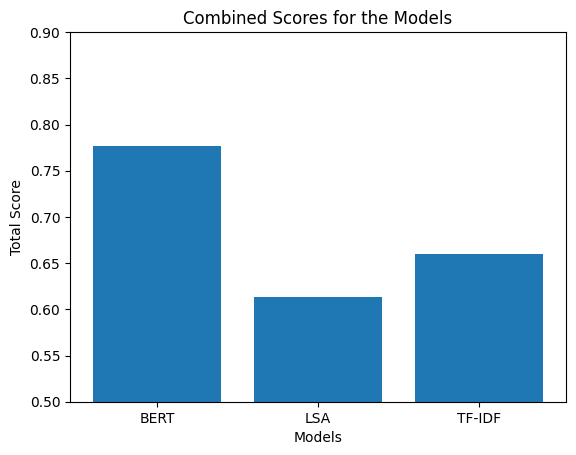

In [ ]:
import matplotlib.pyplot as plt

# Calculate the overall total scores for each model
overall_total_score_bert = (total_score_bert_brave + total_score_bert_outl + total_score_bert_sheep) / 3
overall_total_score_tfidf = (total_score_tfidf_brave + total_score_tfidf_outl + total_score_tfidf_sheep) / 3
overall_total_score_lsa = (total_score_lsa_brave + total_score_lsa_outl + total_score_lsa_sheep) / 3

# Create a list of model names and their corresponding overall total scores
models = ['BERT', 'LSA', 'TF-IDF']
overall_scores = [overall_total_score_bert, overall_total_score_lsa, overall_total_score_tfidf]

# Create a bar chart
plt.bar(models, overall_scores)

# Set the title and labels for the chart
plt.title('Combined Scores for the Models')
plt.xlabel('Models')
plt.ylabel('Total Score')

# Set the range from 0 to 1
plt.ylim(0.5, 0.9)

# Display the chart
plt.show()




##on test data

In [ ]:
len(test_data)



1103

In [ ]:
cosine_sim_bert_test = get_bert_cos_sim(test_data)

In [ ]:
test_data.head(5)

In [ ]:
# call the function get_recommendations with TEST_DATA
print('BERT')
result_test_bert = get_recommendations(test_data, "oryx and crake", cosine_sim_bert_test)
result_test_bert


BERT


,Book_Title,Rating_score,Author_Name,Year_published
0,voyage to alpha centauri,4.19,michael d. o'brien,2013
1,wanderers,3.98,chuck wendig,2019
2,screw the galaxy,3.89,steven campbell,2013
3,the first immortal,3.87,james l. halperin,1998
4,gaslight hades,3.87,grace draven,2017
5,altered starscape,3.76,ian douglas,2015
6,the other side of time,3.75,keith laumer,1965
7,the crystal world,3.63,j.g. ballard,1966
8,the end we start from,3.46,megan hunter,2017
9,the space between the stars,3.38,anne corlett,2017
